# Read SAS Files
The following data can be found here:
https://wwwn.cdc.gov/nchs/nhanes/

In [1]:
# Read SAS file
import pandas as pd

In [2]:
# NHANES 2011-2012 vaccination Immunization
nhanes1112_Vaccination = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/IMQ_G.XPT", format = "xport")

In [3]:
# NHANES 2011-2012 core antibody surface antigen
nhanes1112_BG = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/HEPBD_G.XPT", format = "xport" )

In [4]:
# NHANES 2011-2012 surface antibody
nhanes1112_Antibody = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/HEPB_S_G.XPT", format = "xport")

In [5]:
nhanes1112_Vaccination = nhanes1112_Vaccination[['SEQN','IMQ020']]

In [6]:
nhanes1112_BG = nhanes1112_BG[['SEQN','LBXHBC','LBDHBG']]

In [7]:
nhanes1112_Antibody

,SEQN,LBXHBS
0,62161.0,2.0
1,62162.0,NaN
2,62163.0,2.0
3,62164.0,1.0
4,62165.0,1.0
...,...,...
8732,71912.0,2.0
8733,71913.0,2.0
8734,71914.0,1.0
8735,71915.0,2.0


In [8]:
nhanes1112_No_vaccination = nhanes1112_Vaccination[(nhanes1112_Vaccination['IMQ020']==3.0) | (nhanes1112_Vaccination['IMQ020']==7.0) | (nhanes1112_Vaccination['IMQ020']==9.0)]

In [9]:
nhanes1112_No_vaccination

,SEQN,IMQ020
1,62162.0,9.0
7,62168.0,3.0
14,62175.0,9.0
16,62177.0,3.0
17,62178.0,3.0
...,...,...
9746,71907.0,3.0
9749,71910.0,9.0
9750,71911.0,9.0
9751,71912.0,3.0


In [10]:
nhanes1112_club_1 = pd.merge(nhanes1112_No_vaccination, nhanes1112_Antibody, on="SEQN", how = "left")

In [11]:
nhanes1112_club_2 = pd.merge(nhanes1112_club_1, nhanes1112_BG, on="SEQN", how = "left")

In [12]:
import pandas as pd
import pandas.io.sql as sqlio

In [13]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [14]:
from pandasql import sqldf

In [15]:
query = '''
SELECT SEQN, (CASE WHEN LBXHBC = 1.0 THEN 'Positive' WHEN LBXHBC = 2.0 THEN 'Negative' WHEN LBXHBC IS NULL THEN 'Missing' END) AS Core_Antibody,
(CASE WHEN LBDHBG = 1.0 THEN 'Positive' WHEN LBDHBG = 2.0 THEN 'Negative' WHEN LBDHBG IS NULL THEN 'Missing' END) AS Surface_Antigen,
(CASE WHEN LBXHBS = 1.0 THEN 'Positive' WHEN LBXHBS = 2.0 THEN 'Negative' WHEN LBXHBS IS NULL THEN 'Missing' END) AS Surface_Antibody,
(CASE WHEN IMQ020 = 3.0 THEN 'No Doses' WHEN IMQ020 = 7.0 THEN 'Refused' WHEN IMQ020 = 9.0 THEN "Don't know" END) AS Vaccination
FROM nhanes1112_club_2
'''

In [16]:
nhanes1112_final = sqldf(query)

In [17]:
nhanes1112_final[(nhanes1112_final['Surface_Antigen'] == 'Negative') & (nhanes1112_final['Vaccination'] == "No Doses")]

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination
1,62168.0,Negative,Negative,Positive,No Doses
3,62177.0,Positive,Negative,Negative,No Doses
4,62178.0,Negative,Negative,Negative,No Doses
7,62193.0,Negative,Negative,Positive,No Doses
9,62202.0,Negative,Negative,Negative,No Doses
...,...,...,...,...,...
4459,71891.0,Negative,Negative,Negative,No Doses
4461,71901.0,Negative,Negative,Negative,No Doses
4462,71902.0,Positive,Negative,Negative,No Doses
4463,71907.0,Negative,Negative,Negative,No Doses


In [18]:
nhanes1112_final

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination
0,62162.0,Missing,Missing,Missing,Don't know
1,62168.0,Negative,Negative,Positive,No Doses
2,62175.0,Missing,Missing,Missing,Don't know
3,62177.0,Positive,Negative,Negative,No Doses
4,62178.0,Negative,Negative,Negative,No Doses
...,...,...,...,...,...
4463,71907.0,Negative,Negative,Negative,No Doses
4464,71910.0,Missing,Missing,Missing,Don't know
4465,71911.0,Negative,Negative,Negative,Don't know
4466,71912.0,Negative,Negative,Negative,No Doses


In [19]:
query2 = '''
SELECT SEQN, Core_Antibody, Surface_Antigen, Surface_Antibody, Vaccination, 
(CASE WHEN Surface_Antigen = 'Positive' THEN 'HBV Infection' WHEN (Surface_Antibody = 'Positive') THEN 'Vaccine Immunity' 
WHEN (Surface_Antigen = 'Negative' and Core_Antibody ='Negative' and Surface_Antibody ='Negative') THEN 'No Infection'
WHEN (Core_Antibody = 'Positive' and Surface_Antibody = 'Negative') THEN 'HBV Exposure' END) AS resp_2 
FROM nhanes1112_final
'''

In [20]:
nhanes1112_final_resp = sqldf(query2)

In [21]:
nhanes1112_final_resp[nhanes1112_final_resp['resp_2'].isna()]

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2
0,62162.0,Missing,Missing,Missing,Don't know,None
2,62175.0,Missing,Missing,Missing,Don't know,None
5,62182.0,Missing,Missing,Missing,No Doses,None
8,62201.0,Missing,Missing,Missing,No Doses,None
13,62211.0,Missing,Missing,Missing,No Doses,None
...,...,...,...,...,...,...
4441,71862.0,Missing,Missing,Missing,Don't know,None
4444,71870.0,Missing,Missing,Missing,No Doses,None
4458,71890.0,Missing,Missing,Missing,No Doses,None
4460,71897.0,Missing,Missing,Missing,No Doses,None


In [22]:
nhanes1112_HBV = nhanes1112_final_resp[(nhanes1112_final_resp['resp_2']=='HBV Infection') | (nhanes1112_final_resp['resp_2']=='No Infection')]

In [23]:
# NHANES 2011-2012 Demographic Variable
nhanes1112_Demographic = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/DEMO_G.XPT", format = "xport")

In [24]:
#Added one more variable
Demographic_Variables = ['SEQN','SDDSRVYR','RIAGENDR','RIDAGEYR','RIDRETH3','DMQMILIZ','DMQADFC','DMDBORN4','DMDCITZN',
                        'DMDYRSUS','DMDEDUC2','DMDMARTL','WTINT2YR','WTMEC2YR','SDMVPSU','SDMVSTRA','INDFMPIR']

In [25]:
nhanes1112_Demographic = nhanes1112_Demographic[Demographic_Variables]

In [26]:
#Add HRBR4 in 2015-2016
import numpy as np

In [27]:
nhanes1112_Demographic['DMDHRBR4'] = np.nan

In [28]:
nhanes1112_HBV_Demo = pd.merge(nhanes1112_HBV, nhanes1112_Demographic, on="SEQN", how = "left")

In [29]:
nhanes1112_HBV_Demo

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH3,...,DMDCITZN,DMDYRSUS,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR,DMDHRBR4
0,62178.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,80.0,3.0,...,1.0,NaN,3.0,2.0,12291.154515,13189.875012,1.0,95.0,0.05,NaN
1,62191.0,Negative,Negative,Negative,Don't know,No Infection,7.0,1.0,70.0,4.0,...,1.0,NaN,3.0,3.0,8661.769277,9105.621464,1.0,96.0,0.90,NaN
2,62202.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,36.0,1.0,...,1.0,NaN,2.0,1.0,41155.167164,40844.556107,1.0,102.0,2.83,NaN
3,62205.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,28.0,3.0,...,1.0,NaN,5.0,5.0,103663.693967,105583.964573,1.0,90.0,5.00,NaN
4,62208.0,Negative,Negative,Negative,Don't know,No Infection,7.0,1.0,38.0,2.0,...,2.0,3.0,4.0,1.0,41241.224595,41216.943466,2.0,102.0,1.53,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,71901.0,Negative,Negative,Negative,No Doses,No Infection,7.0,2.0,48.0,7.0,...,1.0,NaN,4.0,1.0,30442.306410,31779.541767,1.0,101.0,0.88,NaN
2884,71907.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,80.0,3.0,...,1.0,NaN,3.0,1.0,47098.572584,50542.386793,1.0,95.0,4.08,NaN
2885,71911.0,Negative,Negative,Negative,Don't know,No Infection,7.0,1.0,27.0,1.0,...,1.0,NaN,5.0,1.0,42165.369652,43039.787442,2.0,102.0,3.25,NaN
2886,71912.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,40.0,3.0,...,1.0,NaN,1.0,1.0,19633.637051,20770.138122,1.0,98.0,1.73,NaN


In [30]:
# NHANES 2011-2012 Insurance
nhanes1112_Insurance = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/HIQ_G.XPT", format = "xport")

In [31]:
Insurance_Variables = ['SEQN','HIQ011','HIQ031A','HIQ031B','HIQ031C','HIQ031D','HIQ031E','HIQ031H','HIQ031I','HIQ031AA']

In [32]:
nhanes1112_Insurance = nhanes1112_Insurance[Insurance_Variables]

In [33]:
nhanes1112_HBV_Demo_Insurance = pd.merge(nhanes1112_HBV_Demo, nhanes1112_Insurance, on="SEQN", how = "left")

In [34]:
query4 = '''
SELECT *, 
(CASE WHEN HIQ011 = 2.0 THEN 1 ELSE 0 END) AS No_Insurance,
(CASE WHEN HIQ011 = 1.0 and HIQ031A = 14.0 THEN 1 ELSE 0 END) AS Private_Insurance,
(CASE WHEN HIQ011 = 1.0 and (HIQ031A IS NOT NULL OR HIQ031B IS NOT NULL OR HIQ031C IS NOT NULL OR HIQ031D IS NOT NULL OR 
HIQ031E IS NOT NULL OR HIQ031H IS NOT NULL OR HIQ031I IS NOT NULL OR HIQ031AA IS NOT NULL) THEN 1 ELSE 0 END) Governement_Insurance
FROM nhanes1112_HBV_Demo_Insurance
'''

In [35]:
nhanes1112_HBV_Demo_Insurance = sqldf(query4)

In [36]:
nhanes1112_HBV_Demo_Insurance = nhanes1112_HBV_Demo_Insurance.drop(columns=['HIQ011','HIQ031A','HIQ031B','HIQ031C','HIQ031D','HIQ031E','HIQ031H','HIQ031I','HIQ031AA'])

In [37]:
nhanes1112_HBV_Demo_Insurance

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH3,...,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR,DMDHRBR4,No_Insurance,Private_Insurance,Governement_Insurance
0,62178.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,80.0,3.0,...,2.0,12291.154515,13189.875012,1.0,95.0,0.05,None,0,0,1
1,62191.0,Negative,Negative,Negative,Don't know,No Infection,7.0,1.0,70.0,4.0,...,3.0,8661.769277,9105.621464,1.0,96.0,0.90,None,0,1,1
2,62202.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,36.0,1.0,...,1.0,41155.167164,40844.556107,1.0,102.0,2.83,None,0,1,1
3,62205.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,28.0,3.0,...,5.0,103663.693967,105583.964573,1.0,90.0,5.00,None,0,1,1
4,62208.0,Negative,Negative,Negative,Don't know,No Infection,7.0,1.0,38.0,2.0,...,1.0,41241.224595,41216.943466,2.0,102.0,1.53,None,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,71901.0,Negative,Negative,Negative,No Doses,No Infection,7.0,2.0,48.0,7.0,...,1.0,30442.306410,31779.541767,1.0,101.0,0.88,None,0,0,1
2884,71907.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,80.0,3.0,...,1.0,47098.572584,50542.386793,1.0,95.0,4.08,None,0,1,1
2885,71911.0,Negative,Negative,Negative,Don't know,No Infection,7.0,1.0,27.0,1.0,...,1.0,42165.369652,43039.787442,2.0,102.0,3.25,None,0,1,1
2886,71912.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,40.0,3.0,...,1.0,19633.637051,20770.138122,1.0,98.0,1.73,None,1,0,0


In [38]:
#Alcohol use
nhanes1112_Alcohol = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/ALQ_G.XPT", format = "xport")

In [39]:
nhanes1112_Alcohol = nhanes1112_Alcohol[['SEQN','ALQ130']]

In [40]:
nhanes1112 = pd.merge(nhanes1112_HBV_Demo_Insurance, nhanes1112_Alcohol, on="SEQN", how = "left")

In [41]:
#Healthcare Visits
nhanes1112_Healthcare = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/HUQ_G.XPT", format = "xport")

In [42]:
nhanes1112_Healthcare = nhanes1112_Healthcare [['SEQN','HUQ050']]

In [43]:
nhanes1112 = pd.merge(nhanes1112, nhanes1112_Healthcare, on="SEQN", how = "left")

In [44]:
#Dialysis
nhanes1112_Dialysis = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/KIQ_U_G.XPT", format = "xport")

In [45]:
nhanes1112_Dialysis = nhanes1112_Dialysis[['SEQN','KIQ025']]

In [46]:
nhanes1112 = pd.merge(nhanes1112, nhanes1112_Dialysis, on="SEQN", how = "left")

In [47]:
#Liver Condition
nhanes1112_Liver_Condition = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/MCQ_G.XPT", format = "xport")

In [48]:
nhanes1112_Liver_Condition = nhanes1112_Liver_Condition[['SEQN','MCQ160L']]

In [49]:
nhanes1112 = pd.merge(nhanes1112, nhanes1112_Liver_Condition, on="SEQN", how = "left")

In [50]:
#Blood Transfusion
nhanes1112_Blood_Transfusion = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/MCQ_G.XPT", format = "xport")

In [51]:
nhanes1112_Blood_Transfusion = nhanes1112_Blood_Transfusion[['SEQN','MCQ092']]

In [52]:
nhanes1112 = pd.merge(nhanes1112, nhanes1112_Blood_Transfusion, on="SEQN", how = "left")

In [53]:
#Healthcare Visits time
nhanes1112_Healthcare_time = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/HUQ_G.XPT", format = "xport")

In [54]:
nhanes1112_Healthcare_time = nhanes1112_Healthcare_time[['SEQN','HUQ060']]

In [55]:
nhanes1112 = pd.merge(nhanes1112, nhanes1112_Healthcare_time, on="SEQN", how = "left")

In [56]:
#Hepatitis C
nhanes1112_Hepatitis_C = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/HCQ_G.XPT", format = "xport")

In [57]:
nhanes1112_Hepatitis_C = nhanes1112_Hepatitis_C[['SEQN']]

In [58]:
import numpy as np
nhanes1112_Hepatitis_C['Hepatitis_C'] = "Yes"

In [59]:
nhanes1112 = pd.merge(nhanes1112, nhanes1112_Hepatitis_C, on="SEQN", how = "left")

In [60]:
Biochemistry_Variables = ['SEQN','LBXSATSI','LBDSALSI','LBXSASSI']

In [61]:
#Biochemistry_Variables
nhanes1112_Biochemistry_Variables = pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/BIOPRO_G.XPT", format = "xport")

In [62]:
nhanes1112_Biochemistry_Variables = nhanes1112_Biochemistry_Variables[Biochemistry_Variables]

In [63]:
nhanes1112 = pd.merge(nhanes1112, nhanes1112_Biochemistry_Variables, on="SEQN", how = "left")

In [64]:
#Platelet count
nhanes1112_Platelet_Count= pd.read_sas("https://wwwn.cdc.gov/Nchs/Nhanes/2011-2012/CBC_G.XPT", format = "xport")

In [65]:
nhanes1112_Platelet_Count = nhanes1112_Platelet_Count[['SEQN','LBXPLTSI']]

In [66]:
nhanes1112 = pd.merge(nhanes1112, nhanes1112_Platelet_Count, on="SEQN", how = "left")

In [67]:
nhanes1112 = nhanes1112[nhanes1112['RIDAGEYR']>=18]

In [68]:
pd.set_option('display.max_columns', None)
nhanes1112.head()

,SEQN,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,SDDSRVYR,RIAGENDR,RIDAGEYR,RIDRETH3,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC2,DMDMARTL,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDFMPIR,DMDHRBR4,No_Insurance,Private_Insurance,Governement_Insurance,ALQ130,HUQ050,KIQ025,MCQ160L,MCQ092,HUQ060,Hepatitis_C,LBXSATSI,LBDSALSI,LBXSASSI,LBXPLTSI
0,62178.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,80.0,3.0,1.0,1.0,1.0,1.0,NaN,3.0,2.0,12291.154515,13189.875012,1.0,95.0,0.05,None,0,0,1,NaN,4.0,NaN,2.0,2.0,NaN,NaN,13.0,42.0,28.0,152.0
1,62191.0,Negative,Negative,Negative,Don't know,No Infection,7.0,1.0,70.0,4.0,1.0,2.0,1.0,1.0,NaN,3.0,3.0,8661.769277,9105.621464,1.0,96.0,0.90,None,0,1,1,3.0,2.0,NaN,2.0,1.0,NaN,NaN,13.0,37.0,16.0,143.0
2,62202.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,36.0,1.0,2.0,NaN,1.0,1.0,NaN,2.0,1.0,41155.167164,40844.556107,1.0,102.0,2.83,None,0,1,1,2.0,1.0,NaN,2.0,2.0,NaN,NaN,38.0,48.0,31.0,214.0
3,62205.0,Negative,Negative,Negative,No Doses,No Infection,7.0,1.0,28.0,3.0,2.0,NaN,1.0,1.0,NaN,5.0,5.0,103663.693967,105583.964573,1.0,90.0,5.00,None,0,1,1,3.0,3.0,NaN,2.0,2.0,NaN,NaN,48.0,46.0,68.0,267.0
4,62208.0,Negative,Negative,Negative,Don't know,No Infection,7.0,1.0,38.0,2.0,2.0,NaN,2.0,2.0,3.0,4.0,1.0,41241.224595,41216.943466,2.0,102.0,1.53,None,1,0,0,1.0,2.0,NaN,2.0,2.0,NaN,NaN,32.0,46.0,28.0,218.0


In [69]:
nhanes1112.shape

(2721, 37)

In [70]:
nhanes1112 = nhanes1112.rename(columns = {'SEQN':'Respondent_sequence_number',
                            'SDDSRVYR':'Data_release_cycle',
                            'RIAGENDR':'Gender',
                            'RIDAGEYR':'Age',
                            'RIDRETH3':'Race_Ethnicity',
                            'DMQMILIZ':'Veteran_Status',
                            'DMQADFC':'Foreign_country',
                            'DMDBORN4':'Country_of_birth',             
                            'DMDCITZN':'Citizenship_status',
                            'DMDYRSUS':'Length_of_time_in_US',
                            'DMDEDUC2':'Education_level',
                            'DMDMARTL':'Marital_status',
                            'WTINT2YR':'Two_year_interview_weight',
                            'WTMEC2YR':'Two_year_MEC_weight',
                            'SDMVPSU':'Masked_variance_PSU',
                            'SDMVSTRA':'Masked_variance_stratum',
                            'INDFMPIR':'Ratio_income_poverty',
                            'DMDHRBR4':'HH_country_of_birth',
                            'ALQ130':'Alcohol_1_year',
                            'HUQ050':'Health_care_1_year',
                            'KIQ025':'Dialysis_1_year',
                            'MCQ160L':'liver_condition',
                            'MCQ092':'Blood_Transfusion',
                            'HUQ060':'Last_Healthcare_Visit',
                            'Hepatitis_C':'Hepatitis_C',
                            'LBXSATSI':'ALT',
                            'LBDSALSI':'Albumin',
                            'LBXSASSI':'AST',
                            'LBXPLTSI':'Platelet_Count'})

In [71]:
nhanes1112[nhanes1112['resp_2']=='HBV Infection'].shape

(32, 37)

In [72]:
import numpy as np
column_mapping = {
    'Gender':{1.0:"male", 2.0:"Female", np.nan:"missing"},
    'Race_Ethnicity':{1.0:"Mexican American",2.0:"Other Hispanic",3.0:"Non-Hispanic White",4.0:"Non-Hispanic Black",6.0:"Non-Hispanic Asian",7.0:"Other Race - Including Multi-Racial"},
    'Veteran_Status':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know", np.nan:"missing"},
    'Foreign_country':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know", np.nan:"missing"},
    'Country_of_birth':{1.0:"US", 2.0:"Other",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Citizenship_status':{1.0:"Citizen",2.0:"Not a citizen",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Length_of_time_in_US':{1.0:"Less than 1 year",2.0:"1-5",3.0:"5-10",4.0:"10-15",5.0:"15-20",6.0:"20-30",7.0:"30-40",8.0:"40-50",9.0:"50 or more",77.0:"Refused",88.0:"Could not determine",99.0:"Don't know",np.nan:"missing"},
    'Education_level':{1.0:"Less Than 9th Grade",2.0:"9-12th Grade",3.0:"High School Grad/GED or Equivalent",4.0:"Some College or AA degree",5.0:"College Graduate or above",7.0:"Refused",9.0:"Don't Know",np.nan:"missing"},
    'Marital_status':{1.0:"Married",2.0:"Widowed",3.0:"Divorced",4.0:"Separated",5.0:"Never married",6.0:"Living with partner",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'HH_Country_of_Birth':{1.0:"US", 2.0:"Other",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Health_care_1_year':{5.397605e-79:"None",1.0:"1",2.0:"2 to 3",3.0:"4 to 9",4.0:"10 to 12",5.0:"13 or more",77.0:"Refused",99.0:"Don't know",np.nan:"missing"},
    'Dialysis_1_year':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'liver_condition':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Blood_Transfusion':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Last_Healthcare_Visit':{1.0:"6 months or less",2.0:"More than 6 months, but not more than 1 year ago",3.0:"More than 1 year, but not more than 3 years ago",4.0:"More than 3 years",5.0:"Never",7.0:"Refused",9.0:"Don't know",np.nan:"missing"},
    'Hepatitis_C_evertold':{1.0:"Yes",2.0:"No",7.0:"Refused",9.0:"Don't know",np.nan:"missing"}
}

nhanes1112.replace(column_mapping,inplace=True)

In [73]:
for i in list(nhanes1112.columns):
    print(i, ":", nhanes1112[(nhanes1112[i]=='missing') | (nhanes1112[i].isna())].shape[0]*100.0/nhanes1112.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Foreign_country : 88.2396177875781
Country_of_birth : 0.0
Citizenship_status : 0.11025358324145534
Length_of_time_in_US : 72.62036016170525
Education_level : 1.7273061374494671
Marital_status : 1.7273061374494671
Two_year_interview_weight : 0.0
Two_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 8.599779492833518
HH_country_of_birth : 100.0
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 41.27159132671812
Health_care_1_year : 0.0
Dialysis_1_year : 96.10437339213524
liver_condition : 1.7273061374494671
Blood_Transfusion : 0.0
Last_Healthcare_Visit : 82.65343623667769
Hepatitis_C : 98.64020580668871
ALT : 1.543550165380375
Albumin : 1.4332965821389194
AST : 1.5803013597941933
Plate

In [74]:
#Remove Last Healthcare Visits
#Remove Length_of_time_in_Us
#Remove Dialysis_1_year

In [75]:
nhanes1112 = nhanes1112.drop(columns=['Foreign_country','Dialysis_1_year','Last_Healthcare_Visit','Length_of_time_in_US'])

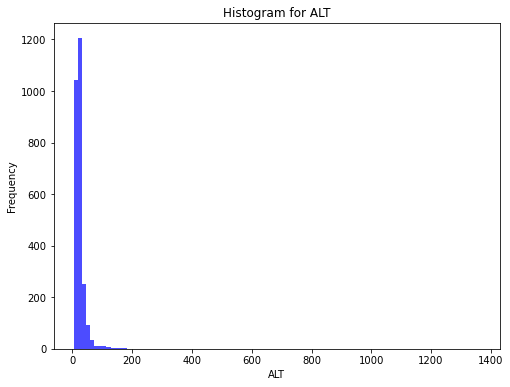

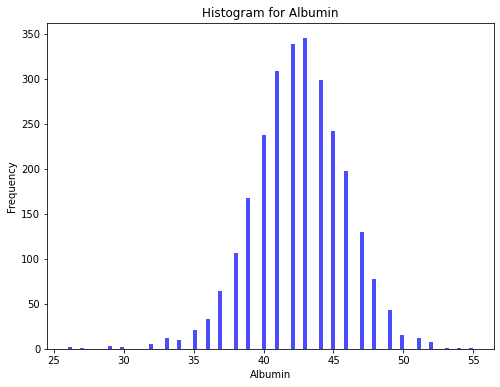

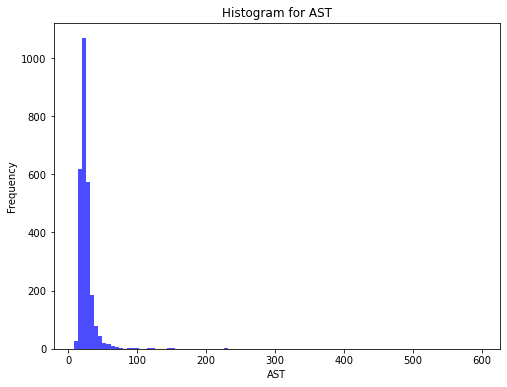

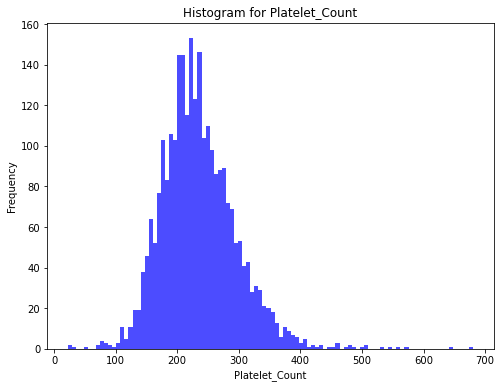

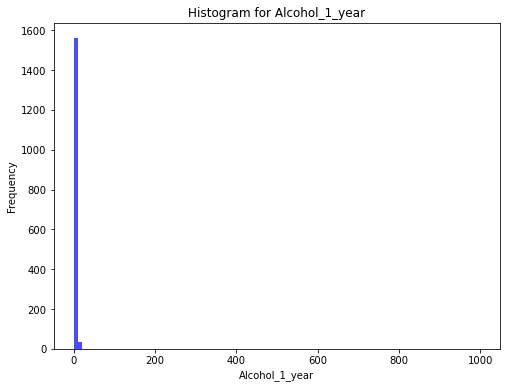

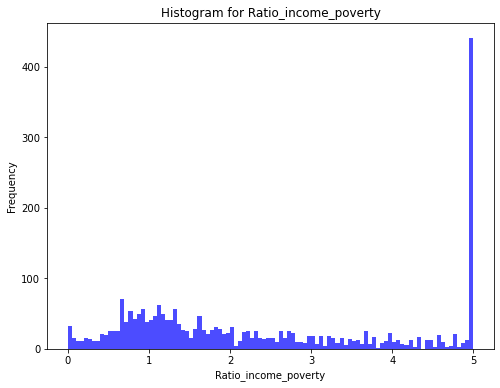

In [76]:
import matplotlib.pyplot as plt
continuous_columns = ['ALT', 'Albumin', 'AST', 'Platelet_Count', 'Alcohol_1_year', 'Ratio_income_poverty']

for column in continuous_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(nhanes1112[~nhanes1112[column].isna()][column], bins=100, color='blue', alpha=0.7)
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [77]:
#Impute ALT, AST, PLT, PST with medians
#Impute income poverty ratio with PSU weighted means
#Impute Alcohol 1 year with weighted means
#Delete rows where Categorical features are missing

In [78]:
# Deleting records where categorical columns have missing values
categorical_columns = ['Education_level','Marital_status','liver_condition']

# Drop rows with missing values in specified categorical columns
nhanes1112 = nhanes1112.dropna(subset=categorical_columns)

In [79]:
#Imputing biochemistry variables
continuous_columns = ['ALT', 'Albumin', 'AST', 'Platelet_Count']

# Impute missing values with median
for column in continuous_columns:
    median_value = nhanes1112[column].median()
    nhanes1112[column].fillna(median_value, inplace=True)

In [80]:
#Imputing alcohol_1_year
alcohol_column = 'Alcohol_1_year'
weights_column = 'Two_year_interview_weight'  

# Calculate the weighted mean for Alcohol_1_year
weighted_mean = (nhanes1112[alcohol_column] * nhanes1112[weights_column]).sum() / nhanes1112[weights_column].sum()

# Impute missing values with the weighted mean for Alcohol_1_year
nhanes1112[alcohol_column].fillna(weighted_mean, inplace=True)

In [81]:
nhanes1112.columns

Index(['Respondent_sequence_number', 'Core_Antibody', 'Surface_Antigen',
       'Surface_Antibody', 'Vaccination', 'resp_2', 'Data_release_cycle',
       'Gender', 'Age', 'Race_Ethnicity', 'Veteran_Status', 'Country_of_birth',
       'Citizenship_status', 'Education_level', 'Marital_status',
       'Two_year_interview_weight', 'Two_year_MEC_weight',
       'Masked_variance_PSU', 'Masked_variance_stratum',
       'Ratio_income_poverty', 'HH_country_of_birth', 'No_Insurance',
       'Private_Insurance', 'Governement_Insurance', 'Alcohol_1_year',
       'Health_care_1_year', 'liver_condition', 'Blood_Transfusion',
       'Hepatitis_C', 'ALT', 'Albumin', 'AST', 'Platelet_Count'],
      dtype='object')

In [82]:
nhanes1112['concat'] = nhanes1112['Masked_variance_stratum'].astype(str) + '_' + nhanes1112['Masked_variance_PSU'].astype(str)

In [83]:
nhanes1112['product'] = nhanes1112['Ratio_income_poverty']*nhanes1112['Two_year_interview_weight']

In [84]:
nhanes1112_temp = nhanes1112.groupby('concat').sum()['product'].reset_index()

In [85]:
nhanes1112_temp_2 = nhanes1112.groupby('concat').sum()['Two_year_interview_weight'].reset_index()

In [86]:
nhanes1112_temp_3  = pd.merge(nhanes1112_temp, nhanes1112_temp_2, on="concat", how = "left")

In [87]:
nhanes1112_temp_3['rip'] = nhanes1112_temp_3['product']/nhanes1112_temp_3['Two_year_interview_weight']

In [88]:
nhanes1112_temp_4 = nhanes1112_temp_3[['concat','rip']]

In [89]:
nhanes1112 = pd.merge(nhanes1112,nhanes1112_temp_4, on='concat', how='left')

# Fill missing values in col_to_fill with mapping_value
nhanes1112['Ratio_income_poverty'] = nhanes1112['Ratio_income_poverty'].fillna(nhanes1112['rip'])

In [90]:
nhanes1112 = nhanes1112.drop(columns=['product','rip'])

In [91]:
nhanes1112 = nhanes1112.drop(columns=['HH_country_of_birth'])

In [92]:
# Replace "missing" with NaN
nhanes1112.replace(np.nan,'No',inplace=True)

# Drop rows with any missing values
nhanes1112 = nhanes1112.dropna()

In [93]:
for i in list(nhanes1112.columns):
    print(i, ":", nhanes1112[(nhanes1112[i]=='missing') | (nhanes1112[i].isna())].shape[0]*100.0/nhanes1112.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Country_of_birth : 0.0
Citizenship_status : 0.11025358324145534
Education_level : 1.7273061374494671
Marital_status : 1.7273061374494671
Two_year_interview_weight : 0.0
Two_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 0.0
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 0.0
Health_care_1_year : 0.0
liver_condition : 1.7273061374494671
Blood_Transfusion : 0.0
Hepatitis_C : 0.0
ALT : 0.0
Albumin : 0.0
AST : 0.0
Platelet_Count : 0.0
concat : 0.0


In [94]:
# Drop rows with any missing values
nhanes1112 = nhanes1112.dropna()
nhanes1112

,Respondent_sequence_number,Core_Antibody,Surface_Antigen,Surface_Antibody,Vaccination,resp_2,Data_release_cycle,Gender,Age,Race_Ethnicity,Veteran_Status,Country_of_birth,Citizenship_status,Education_level,Marital_status,Two_year_interview_weight,Two_year_MEC_weight,Masked_variance_PSU,Masked_variance_stratum,Ratio_income_poverty,No_Insurance,Private_Insurance,Governement_Insurance,Alcohol_1_year,Health_care_1_year,liver_condition,Blood_Transfusion,Hepatitis_C,ALT,Albumin,AST,Platelet_Count,concat
0,62178.0,Negative,Negative,Negative,No Doses,No Infection,7.0,male,80.0,Non-Hispanic White,Yes,US,Citizen,High School Grad/GED or Equivalent,Widowed,12291.154515,13189.875012,1.0,95.0,0.05,0,0,1,1.889388,10 to 12,No,No,No,13.0,42.0,28.0,152.0,95.0_1.0
1,62191.0,Negative,Negative,Negative,Don't know,No Infection,7.0,male,70.0,Non-Hispanic Black,Yes,US,Citizen,High School Grad/GED or Equivalent,Divorced,8661.769277,9105.621464,1.0,96.0,0.90,0,1,1,3.000000,2 to 3,No,Yes,No,13.0,37.0,16.0,143.0,96.0_1.0
2,62202.0,Negative,Negative,Negative,No Doses,No Infection,7.0,male,36.0,Mexican American,No,US,Citizen,9-12th Grade,Married,41155.167164,40844.556107,1.0,102.0,2.83,0,1,1,2.000000,1,No,No,No,38.0,48.0,31.0,214.0,102.0_1.0
3,62205.0,Negative,Negative,Negative,No Doses,No Infection,7.0,male,28.0,Non-Hispanic White,No,US,Citizen,College Graduate or above,Never married,103663.693967,105583.964573,1.0,90.0,5.00,0,1,1,3.000000,4 to 9,No,No,No,48.0,46.0,68.0,267.0,90.0_1.0
4,62208.0,Negative,Negative,Negative,Don't know,No Infection,7.0,male,38.0,Other Hispanic,No,Other,Not a citizen,Some College or AA degree,Married,41241.224595,41216.943466,2.0,102.0,1.53,1,0,0,1.000000,2 to 3,No,No,No,32.0,46.0,28.0,218.0,102.0_2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2716,71901.0,Negative,Negative,Negative,No Doses,No Infection,7.0,Female,48.0,Other Race - Including Multi-Racial,No,US,Citizen,Some College or AA degree,Married,30442.306410,31779.541767,1.0,101.0,0.88,0,0,1,1.889388,4 to 9,No,No,No,12.0,41.0,30.0,367.0,101.0_1.0
2717,71907.0,Negative,Negative,Negative,No Doses,No Infection,7.0,male,80.0,Non-Hispanic White,Yes,US,Citizen,High School Grad/GED or Equivalent,Married,47098.572584,50542.386793,1.0,95.0,4.08,0,1,1,1.889388,4 to 9,No,No,No,12.0,38.0,20.0,151.0,95.0_1.0
2718,71911.0,Negative,Negative,Negative,Don't know,No Infection,7.0,male,27.0,Mexican American,No,US,Citizen,College Graduate or above,Married,42165.369652,43039.787442,2.0,102.0,3.25,0,1,1,5.000000,1,No,No,No,20.0,48.0,19.0,156.0,102.0_2.0
2719,71912.0,Negative,Negative,Negative,No Doses,No Infection,7.0,male,40.0,Non-Hispanic White,No,US,Citizen,Less Than 9th Grade,Married,19633.637051,20770.138122,1.0,98.0,1.73,1,0,0,7.000000,1,No,No,No,38.0,41.0,26.0,217.0,98.0_1.0


In [95]:
# Replace "missing" with NaN
nhanes1112.replace("missing",np.nan,inplace=True)

# Drop rows with any missing values
nhanes1112 = nhanes1112.dropna()

In [96]:
for i in list(nhanes1112.columns):
    print(i, ":", nhanes1112[(nhanes1112[i]=='missing') | (nhanes1112[i].isna())].shape[0]*100.0/nhanes1112.shape[0])

Respondent_sequence_number : 0.0
Core_Antibody : 0.0
Surface_Antigen : 0.0
Surface_Antibody : 0.0
Vaccination : 0.0
resp_2 : 0.0
Data_release_cycle : 0.0
Gender : 0.0
Age : 0.0
Race_Ethnicity : 0.0
Veteran_Status : 0.0
Country_of_birth : 0.0
Citizenship_status : 0.0
Education_level : 0.0
Marital_status : 0.0
Two_year_interview_weight : 0.0
Two_year_MEC_weight : 0.0
Masked_variance_PSU : 0.0
Masked_variance_stratum : 0.0
Ratio_income_poverty : 0.0
No_Insurance : 0.0
Private_Insurance : 0.0
Governement_Insurance : 0.0
Alcohol_1_year : 0.0
Health_care_1_year : 0.0
liver_condition : 0.0
Blood_Transfusion : 0.0
Hepatitis_C : 0.0
ALT : 0.0
Albumin : 0.0
AST : 0.0
Platelet_Count : 0.0
concat : 0.0
